# Поиск каверов композиций
<br>Разработка ML-модели для сопоставления текстов музыкальных произведений и для поиска каверов (вариации обработки оригинала с элементами новой аранжировки) по их текстам

<br>**Описание проекта**
<br>Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей.
<br>Если мы умеем с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков.
<br>Например:
- по желанию пользователя можем полностью исключить каверы из рекомендаций;
- показать все каверы на любимый трек пользователя;
- контролировать долю каверов в ленте пользователя.

<br>**Цель проекта**
<br>Необходимо разработать ML-продукт, который:
- классифицирует треки по признаку кавер-некавер;
- связывает (группирует) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

<br>**Описание данных**
- Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:
    - track_id - уникальный идентификатор трека;
    - track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
    - original_track_id - уникальный идентификатор исходного трека.
- Метаинформация:
    - track_id - уникальный идентификатор трека;
    - dttm - первая дата появления информации о треке;
    - title - название трека;
    - language - язык исполнения;
    - isrc - международный уникальный идентификатор трека;
    - genres - жанры;
    - duration - длительность трека.
- Текст песен:
    - track_id - уникальный идентификатор трека;
    - lyricId - уникальный идентификатор текста;
    - text - текст трека.

<br>**Целевые метрики**

1. `ROC-AUC` (Receiver Operating Characteristic - Area Under the Curve) является метрикой,
   <br>которая оценивает качество бинарной классификации, учитывая полноту (True Positive Rate) и
   <br>специфичность (True Negative Rate) модели.
   <br>ROC-AUC измеряет способность модели различать между классами и представляет площадь под кривой ROC.
   <br>ROC-AUC особенно полезна, когда важно контролировать баланс между ложно-положительными и ложно-отрицательными предсказаниями.
   <br>Она также устойчива к несбалансированным классам.
3. `F1`-мера является метрикой, которая оценивает точность и полноту модели для бинарной классификации.
   <br>F1-мера является гармоническим средним между точностью (precision) и полнотой (recall).
   <br>Она особенно полезна, когда важно достичь баланса между точностью и полнотой.
   <br>F1-мера хорошо работает, когда классы сбалансированы или когда важно минимизировать как ложно-положительные, так и ложно-отрицательные предсказания.

**План выполнения**
1. Загрузка данных и первичное знакомство с ними;
2. Объединение датафреймов для построения baseline;
3. Кодирование данных для baseline;
4. Получение baseline предсказаний;
5. Дополнение данных признаками:
   - кластеризация;
   - обогащение дополнительными данными из внешних источников;
6. Кодирование дополненных данных;
7. Формирование обучающей и тестовой выборок;
8. Обучение моделей трёх различных структур;
9. Получение предсказаний на кросс-валидации;
10. Подбор гиперпараметров;
11. Выбор лучшей модели;
12. Проверка модели на отложенной выборке;
13. Составление отчёта о проделанной работе.

## Настройка рабочей среды

In [1]:
# !pip install seaborn
# !pip install psycopg2-binary
# !pip install python-dotenv
# !pip install sentence_transformers
# !pip install catboost

In [94]:
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from catboost import Pool, CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV

try:
    import mlflow
    import psycopg2 as psycopg
    from dotenv import load_dotenv
except:
    import sys
    from google.colab import drive
    from google.colab import userdata

Установка констант

In [3]:
try:
    load_dotenv()
    connection = {"sslmode": "require",
                  "target_session_attrs": "read-write"}
    postgres_credentials = {"host": os.getenv("DB_HOST"),
                            "port": os.getenv("DB_PORT"),
                            "dbname": os.getenv("DB_NAME"),
                            "user": os.getenv("DB_USERNAME"),
                            "password": os.getenv("DB_PASSWORD")}
    TRACKING_SERVER_HOST = "127.0.0.1"
    TRACKING_SERVER_PORT = 5000
    EXPERIMENT_NAME = 'text_covers'
    RUN_NAME = ['baseline_0_registry', 'logreg_0_registry', 'catboost_0_registry']
    REGISTRY_MODEL_NAME = ['baseline', 'logistic_regression', 'catboost']
    ASSETS_DIR = 'assets/'
    COVERS_PATH = 'data/music_covers.json'
    LYRICS_PATH = 'data/music_lyrics.json'
    META_DATA_PATH = 'data/music_meta.json'
except:
    drive.mount('/content/drive')
    COVERS_PATH = userdata.get('covers')
    LYRICS_PATH = userdata.get('lyrics')
    META_DATA_PATH = userdata.get('meta')

BATCH_SIZE = 100
RANDOM_STATE = 42
MAX_TOKEN_LEN = 512

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)
sns.set_style("white")
sns.set_theme(style="whitegrid")
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Импорт класса для проведения исследоваия

In [4]:
try:
    from research_class import DatasetExplorer
except:
    from google.colab import userdata
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(userdata.get('my_module'))
    import research_class
    research_class.DatasetExplorer

## Загрузка данных

In [5]:
covers = pd.read_json(COVERS_PATH, orient='records', lines=True)
lyrics = pd.read_json(LYRICS_PATH, orient='records', lines=True)
meta = pd.read_json(META_DATA_PATH, orient='records', lines=True)

np.array(covers).shape, np.array(lyrics).shape, np.array(meta).shape

((71597, 3), (11414, 3), (71769, 7))

### lyrics

In [6]:
explorer_lyrics = DatasetExplorer(lyrics, target=None)

In [7]:
explorer_lyrics.explore_dataset(assets_dir=None, list_column=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


,lyricId,text,track_id
5908,c417dcedbdb1278d987567fd99f2b31d,У неё на запястье cartie\nВ её бокале bacardi\...,c33f73686c3e6fbe81722e4bd9ceceeb
8949,83128615c4850f2398620440436d1371,Как тебя взять и забыть\nНе встречать тебя вез...,0388be82e560291ab1b3a96a24b6a24d
5665,e143954e84e0e203a3834a2510596548,Mandó Jesús el gran Consolador\nÉl vino con su...,49da7e09a60d43cf88873a6438de9194
3538,33b340743ddafd189d287e1ccc5e3e6a,Come on\nCome on\nCome on\nCome on\nDidn't I m...,544d8a7bb8401b0c7450ed9d6950a1fc
6248,8ab43eb4ac2d8cbad53da17bd9fc794b,"She thinks she missed the train to Mars, she's...",281a1dc64294e48c2b884c3d194ff51d


количество полных дубликатов строк: 0
количество пропущенных значений:
lyricId     0
text        0
track_id    0
dtype: int64
Количество уникальных значений в столбце 'lyricId': 10915
Соотношение уникальных значений и общего количества записей в столбце 'lyricId': 0.96

Количество уникальных значений в столбце 'track_id': 10277
Соотношение уникальных значений и общего количества записей в столбце 'track_id': 0.90



#### Выводы:
- тексты представлены на различных языках (английский, русский, испанский и др.);
- явных повторов строк не обнаружено, при этом количество уникальных ID текстов и треков меньше;
  <br>чем всего строк, что означает использование текстов в других треках;
- пропущенных значений в данных не обнаружено

### meta

In [8]:
explorer_meta = DatasetExplorer(meta, target=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


,track_id,dttm,title,language,isrc,genres,duration
40169,c0840baaf23114d079939d40d9be37a8,1.672952e+12,Sweet Disposition,EN,USM952300001,"[ROCK, ALLROCK]",234670.0
68734,7c29472522f674da8fe8fb7a5b6b31c1,1.549411e+12,Sunflower,EN,FR10S1938030,[POP],155810.0
33349,22296461d41d5795ef6d4ee0141e51f0,1.644786e+12,Bajo La Luz de la Luna,ES,QZDFP1937971,"[ROCK, ALLROCK]",211750.0
47549,e5f9f58131e23ee65c947e5fdbc81647,1.359922e+12,Demons,EN,USUM71201071,"[ALTERNATIVE, ROCK, ALLROCK]",177500.0
24617,45bf1523b6b064ac3ccdd157c2ee2af2,1.623426e+12,Shape Of You,EN,QZGWX2211972,"[POP, DANCE]",161950.0


количество полных дубликатов строк: 0
количество пропущенных значений:
track_id        1
dttm            1
title           1
language    49800
isrc          314
genres          0
duration        1
dtype: int64


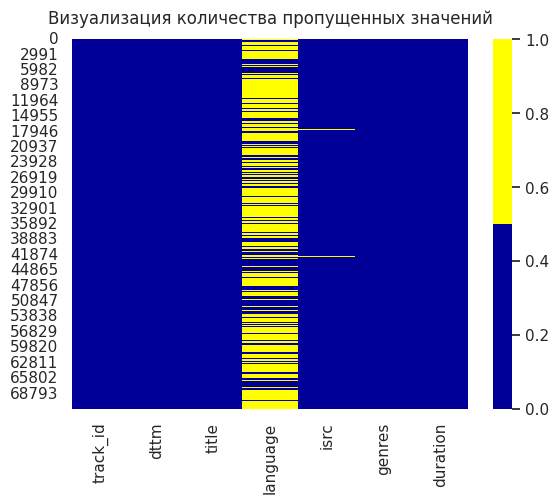

Процент пропущенных значений в признаках:
track_id: 0.00%
dttm: 0.00%
title: 0.00%
language: 69.39%
isrc: 0.44%
duration: 0.00%
Количество уникальных значений в столбце 'track_id': 71768
Соотношение уникальных значений и общего количества записей в столбце 'track_id': 1.00



In [9]:
explorer_meta.explore_dataset(assets_dir=None, list_column='genres')

In [10]:
print(f"Количество уникальных записей language: {meta['language'].nunique()}")

Количество уникальных записей language: 85


#### Выводы:
- явных повторов строк не обнаружено;
- количество стран в колонке `language` - 85;
- информацию о страннах имеют около 30% записей;
- все `track_id` уникальны;
- даты представлены в unix формате;
- можно удалить признаки:
  - `duration` - не несёт важной информации, т.к. продолжительность кавера может отличаться от исходника
  - `genres` - не несёт важной информации, т.к. жанр кавера может отличаться от исходника
  - `isrc` - не несёт важной информации, т.к. имеется признак `track_id`, а ещё в нём есть пропуски

### covers

In [11]:
explorer_covers = DatasetExplorer(covers, target='track_remake_type')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


,original_track_id,track_id,track_remake_type
48596,None,36bc4babedd00e207fad95f834a79e33,COVER
39189,None,951a24ddad24ca432766236946cb6d66,COVER
48106,None,a9a33d68fd3c250487e63b786741d1b4,COVER
62168,None,55ea4ce19deb461086c13c23c17d2b46,COVER
49151,None,3ac81da3dde2e751f8b8ce85c7952606,COVER


количество полных дубликатов строк: 0
количество пропущенных значений:
original_track_id    66776
track_id                 0
track_remake_type        0
dtype: int64


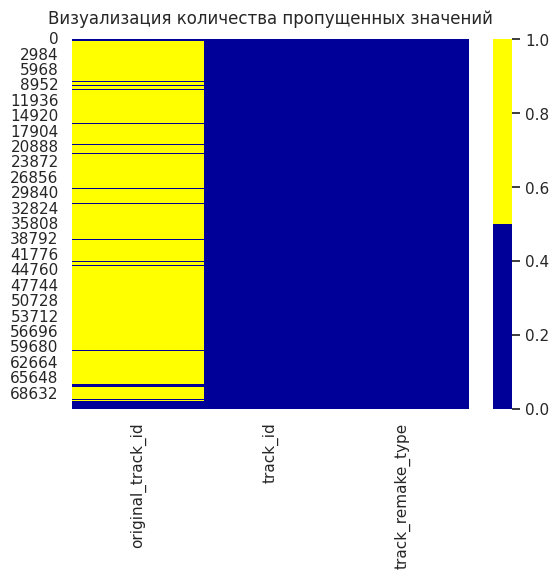

Процент пропущенных значений в признаках:
original_track_id: 93.27%
Количество уникальных значений в столбце 'original_track_id': 4468
Соотношение уникальных значений и общего количества записей в столбце 'original_track_id': 0.06

Количество уникальных значений в столбце 'track_id': 71597
Соотношение уникальных значений и общего количества записей в столбце 'track_id': 1.00

Соотношение классов целевой переменной:
			track_remake_type
ORIGINAL     4293
COVER       67304
Name: count, dtype: int64


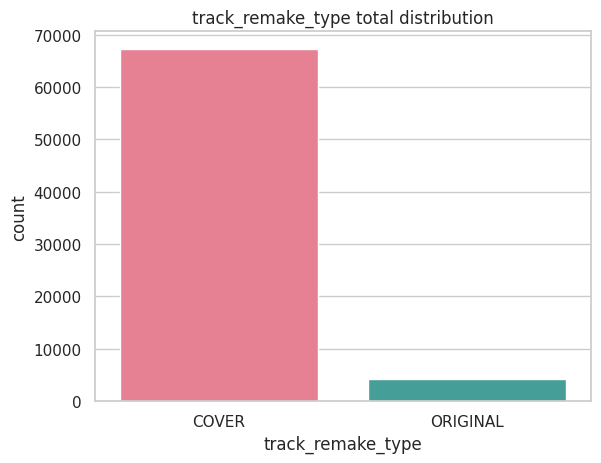

In [12]:
explorer_covers.explore_dataset(assets_dir=None, list_column=None)

In [13]:
print(f"Оригинальных треков указано: {round(covers['original_track_id'].count() / covers['track_id'].count() * 100, 2)}% записей")

Оригинальных треков указано: 6.73% записей


#### Выводы:
- дубликатов строк не обнаружено;
- все `track_id` уникальны;
- классы целевой переменной крайне несбалансированы:
  <br>количество указанных оригинальных треков - 6.73 % от общего числа треков

### Формирование baseline датафрейма

In [14]:
covers_base = covers.copy()
covers_base.dropna(subset='original_track_id', inplace=True)
cover_lyric = (covers_base
               .merge(lyrics, on='track_id', how='left')
               .merge(meta, on='track_id', how='left')
              )

cover_lyric.dropna(subset=['text'], inplace=True)
cover_lyric.reset_index(inplace=True)

Формирование списков признаков

In [15]:
ids = [col for col in cover_lyric.columns if 'id' in col.lower()]
ids.append('isrc')
target = ['track_remake_type']
num_features = cover_lyric.select_dtypes(include=['number']).columns
text_features = ['text']

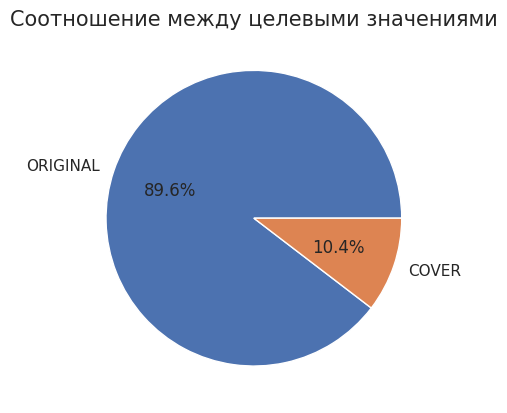

In [16]:
labels = cover_lyric['track_remake_type'].value_counts().index
sizes = [cover_lyric['track_remake_type'].value_counts().iloc[0],
         cover_lyric['track_remake_type'].value_counts().iloc[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Соотношение между целевыми значениями', size=15)
plt.savefig(os.path.join(ASSETS_DIR, f'target distribution in baseline data.png'))
plt.show()

#### Вывод:
- данные объединены;
- удалены пропущенные тексты;
- сформированы списки признаков;
- проверен баланс классов в сформированном датафрейме.

## Подготовка данных для обучения

### baseline_data

In [18]:
text_sentences = np.array(cover_lyric['text'])
title_sentences = np.array(cover_lyric['title'])

try:
    title_embeddings = pd.read_csv('data/title_embeddings.csv')
    text_embeddings = pd.read_csv('data/text_embeddings.csv')
except:
    model = SentenceTransformer('sentence-transformers/LaBSE')  # архитектура LaBSE (Language-agnostic BERT Sentence Embedding)
    title_embeddings = model.encode(title_sentences)
    title_embeddings_df = pd.DataFrame(title_embeddings)
    title_embeddings_df.to_csv('data/title_embeddings.csv', index=False)
    print("Файл title_embeddings.csv успешно сохранен.")
    text_embeddings = model.encode(text_sentences)
    text_embeddings_df = pd.DataFrame(text_embeddings)
    text_embeddings_df.to_csv('data/text_embeddings.csv', index=False)
    print("Файл text_embeddings.csv успешно сохранен.")
text_embeddings.shape, title_embeddings.shape

((3599, 768), (3599, 768))

Кодирование целевой переменной

In [19]:
label_encoder = LabelEncoder()
cover_lyric['is_cover'] = label_encoder.fit_transform(np.array(cover_lyric['track_remake_type']).ravel())
cover_lyric['is_cover'] = cover_lyric['is_cover'].map({0: 1, 1: 0})
target = 'is_cover'

Разделение на обучающую и тестовую выборки

In [109]:
covers_data = text_embeddings.merge(cover_lyric[['dttm', 'duration', 'is_cover']], left_index=True, right_index=True)
X_train, X_test, y_train, y_test = train_test_split(covers_data,
                                                    covers_data[target],
                                                    test_size=0.1,
                                                    random_state=RANDOM_STATE,
                                                    stratify=covers_data[target])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3239, 771), (360, 771), (3239,), (360,))

### main_data

Кластеризация данных

In [111]:
cluster_model = KMeans(n_clusters=10, random_state=RANDOM_STATE)
cluster_labels = cluster_model.fit_predict(covers_data)

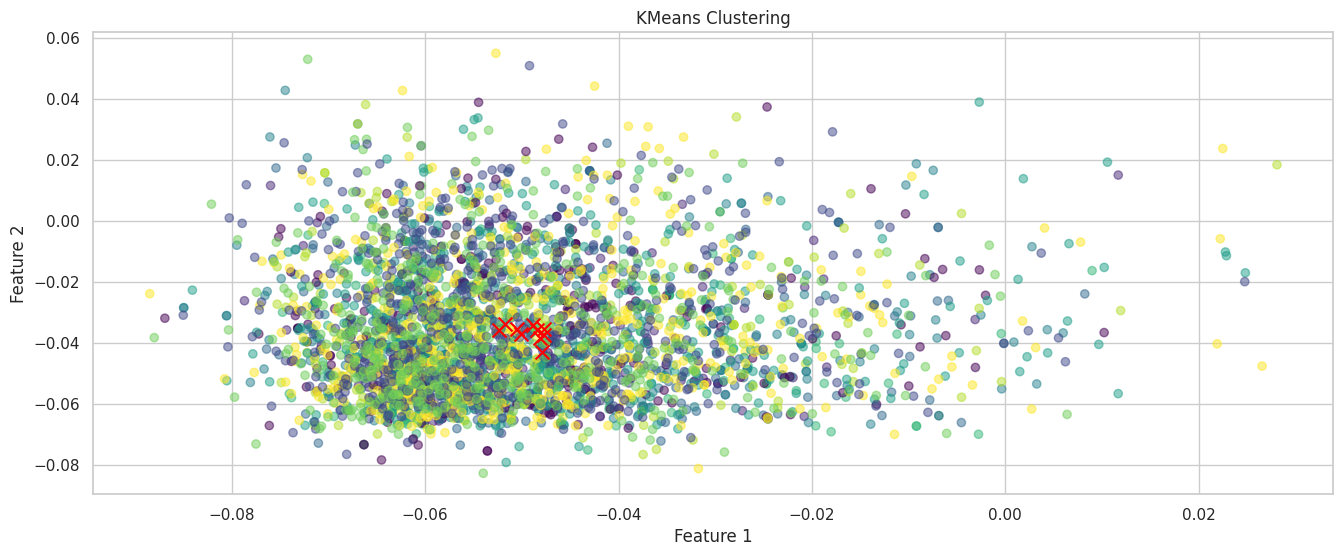

In [137]:
plt.figure(figsize=(16, 6))
labels = cluster_model.predict(covers_data.drop('cluster', axis=1))
centroids = cluster_model.cluster_centers_

plt.scatter(covers_data.iloc[:, 0], covers_data.iloc[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KMeans Clustering')

plt.show()

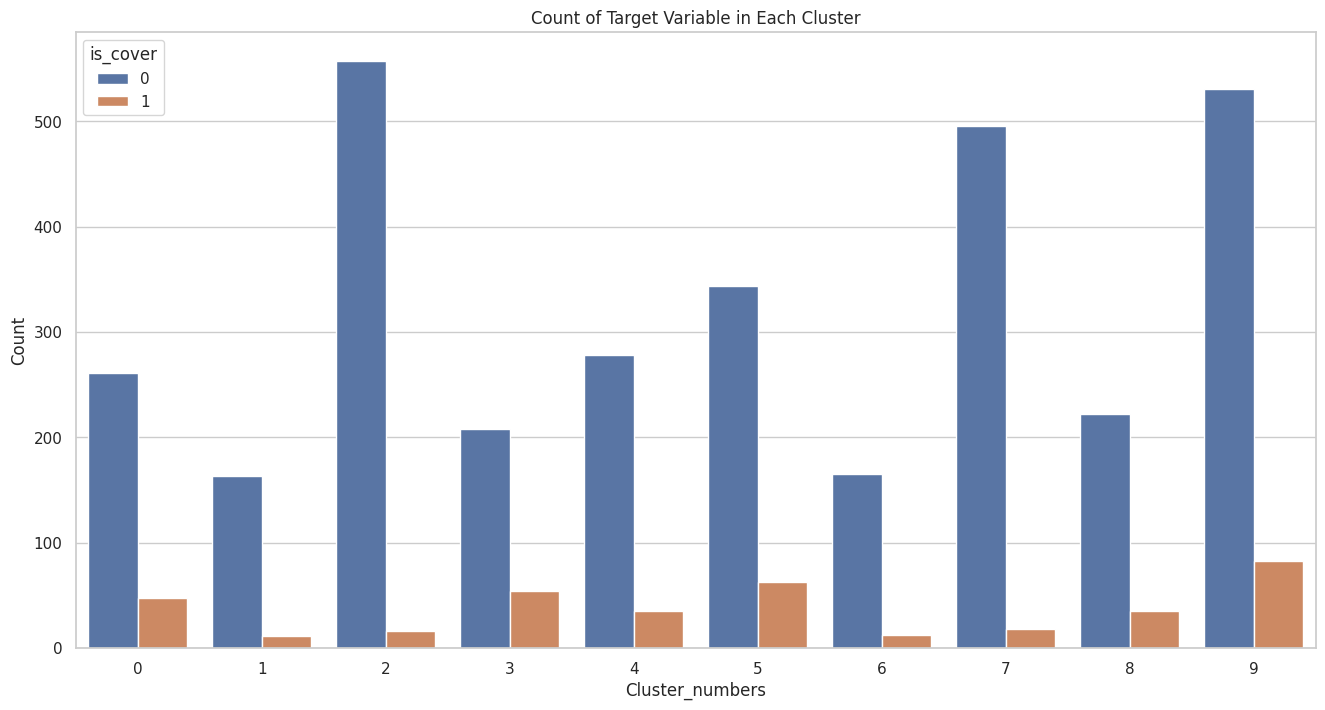

In [129]:
plt.figure(figsize=(16, 8))
sns.countplot(x='cluster', hue=target, data=covers_data)
plt.xlabel('Cluster_numbers')
plt.ylabel('Count')
plt.title('Count of Target Variable in Each Cluster')

plt.show()

### Вывод:
- получены эмбеддинги текстов и наименований при помощи библиотеки `sentence_transformer` на архитектуре LaBSE;
- выбор данной архитектуры обусловлен её способностью распознавать и сравнивать тексты на более, чем 100 языках;
- наименования могут быть потенциальным источником утечки данных, поэтому их использование пока не предполагается;
- значения целевой переменной закодированы в числа;
- данные разделены на обучающую и тестовую выборки.

## Обучение моделей

### Baseline

результаты кросс-вадидации: {'fit_time': 0.312, 'score_time': 0.05, 'test_roc_auc': 0.883, 'test_f1': 0.46}


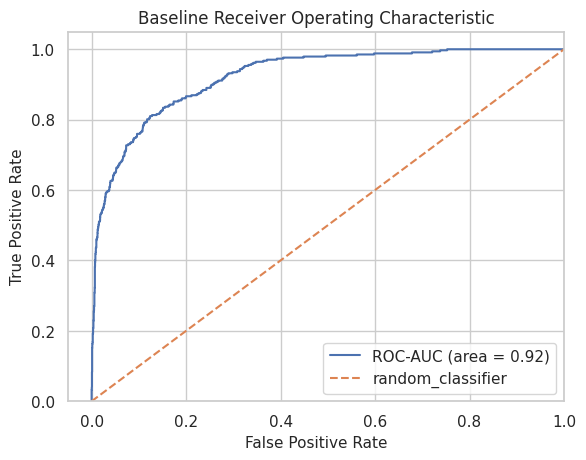

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [23]:
baseline_params = {'class_weight':'balanced',
                   'C':1.0,
                   'penalty':'l2',
                   'max_iter':1000,
                   'random_state':RANDOM_STATE}
baseline = LogisticRegression(**baseline_params)

baseline.fit(X_train, y_train)
cv_strategy = StratifiedKFold(n_splits=4)
cv_res = cross_validate(baseline,
						X_train,
						y_train,
						cv=cv_strategy,
						n_jobs=-1,
						scoring=['roc_auc', 'f1'])
for key, value in cv_res.items():
	cv_res[key] = round(value.mean(), 3)
print(f"результаты кросс-вадидации: {cv_res}")

# Визуализация кривой ROC
y_pred_proba = baseline.predict_proba(X_train)[:, 1]
roc_auc_value = roc_auc_score(y_train, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
plt.plot(fpr, tpr, linewidth=1.5, label='ROC-AUC (area = %0.2f)' % roc_auc_value)
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1.5, label='random_classifier')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('Baseline Receiver Operating Characteristic', fontsize=12)
plt.legend(loc='lower right')
plt.savefig(os.path.join(ASSETS_DIR, f'Baseline Receiver Operating Characteristic.png'))
plt.show()

baseline

Вывод:

- в качестве базовой модели принята `LogisticRegression` на минимальном наборе данных;
- при её обучении с использованием кросс-валидации получены метрики `ROC-AUC: 0.877`, `F1-мера: 0.491`;
- модель с гиперпараметрами и метриками сохранена.

### CatBoost

результаты кросс-вадидации: {'fit_time': 92.586, 'score_time': 0.236, 'test_roc_auc': 0.915, 'test_f1': 0.665}


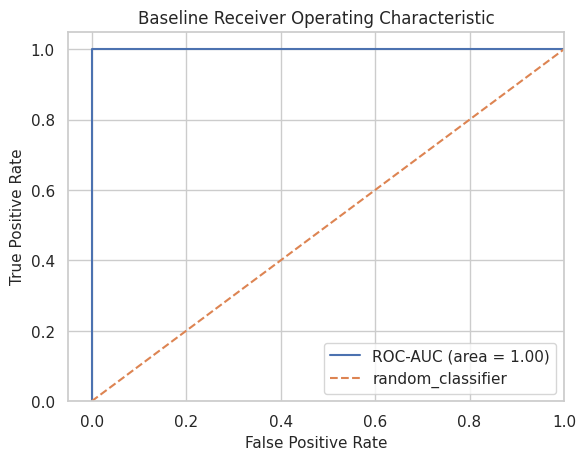

In [62]:
cb_params = {'iterations': 300,
             'auto_class_weights':'Balanced',
             'verbose': False,
             'random_state': RANDOM_STATE}

model_cb = CatBoostClassifier(**cb_params)
# train_pool = Pool(X_train_cb, y_train_cb, text_features=['text'])
model_cb.fit(X=X_train,
             y=y_train,
             text_features=None,
             embedding_features=None)
cv_strategy = StratifiedKFold(n_splits=4)
cv_res = cross_validate(model_cb,
						X_train,
						y_train,
						cv=cv_strategy,
						n_jobs=4,
						scoring=['roc_auc', 'f1'])
for key, value in cv_res.items():
	cv_res[key] = round(value.mean(), 3)
print(f"результаты кросс-вадидации: {cv_res}")

# Визуализация кривой ROC
y_pred_proba = model_cb.predict_proba(X_train)[:, 1]
roc_auc_value = roc_auc_score(y_train, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
plt.plot(fpr, tpr, linewidth=1.5, label='ROC-AUC (area = %0.2f)' % roc_auc_value)
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1.5, label='random_classifier')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('Baseline Receiver Operating Characteristic', fontsize=12)
plt.legend(loc='lower right')
plt.show()

model_cb

Вывод:
- обучена модель `CatBoost` на миниммальном наборе данных;
- при её обучении с использованием кросс-валидации получены метрики `ROC-AUC: 0.915`, `F1-мера: 0.665`;
- модель с гиперпараметрами и метриками сохранена.

In [65]:
# Логирование эксперимента
# !pip freeze > requirements.txt
pip_requirements = "requirements.txt"
signature = mlflow.models.infer_signature(X_train.values, y_train.values)
metadata = {
    "author": "denis_zeit",
    "training_date": "2024-04-11",
    "metrics": {'roc-auc': 0.915, 'f1': 0.665},
    "hyperparameters": {'iterations': 300,
                        'auto_class_weights':'Balanced',
                        'verbose': False,
                        'random_state':42},
    "data_used": 'baseline_data',
    "library_versions": {"mlflow": "2.11.3",
                         "catboost": "1.2.3",
                         "sentence-transformers": "2.6.1"}
}
input_example = (X_train).iloc[0].to_dict()
code_paths = ['music_covers.ipynb', 'research_class.py']
cv_res = {'fit_time': 92.586, 'score_time': 0.236, 'test_roc_auc': 0.915, 'test_f1': 0.665}

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
experiment_id = mlflow.set_experiment(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME[2], experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_params(cb_params)
    mlflow.log_metrics(cv_res)
    model_info = mlflow.catboost.log_model(
        cb_model=model_cb,
        artifact_path="models",
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        metadata=metadata,
        code_paths=code_paths,
        registered_model_name=REGISTRY_MODEL_NAME[2],
        await_registration_for=60
		)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
run = mlflow.get_run(run_id)
assert run.info.status == "FINISHED"

Successfully registered model 'catboost'.
2024/04/11 13:32:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: catboost, version 1
Created version '1' of model 'catboost'.


## Выбор лучшей модели

In [67]:
connection.update(postgres_credentials)
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        # cur.execute(f"SELECT table_name FROM information_schema.tables WHERE table_schema='public'")
        # table_data = []
        # for table_name in cur.fetchall():
        #     cur.execute(f"SELECT COUNT(*) FROM {table_name[0]}")
        #     table_data.append((table_name[0], cur.fetchone()[0]))
        # print('Находящиеся в базе таблицы:')
        # display(pd.DataFrame(table_data, columns=['table_name', 'number_of_rows']))

        cur.execute("""
                       SELECT
                         model_versions.name AS model_name,
                         model_versions.version,
                         STRING_AGG(metrics.key || '=' || metrics.value, '; ') AS metrics,
                         metrics.run_uuid
                       FROM metrics
                         LEFT JOIN model_versions ON model_versions.run_id=metrics.run_uuid
                       WHERE metrics.key NOT IN ('fit_time', 'score_time')
                       GROUP BY model_versions.name, model_versions.version, metrics.run_uuid
                       ORDER BY metrics DESC
                       """)
        table_data = cur.fetchall()
        table_columns = [desc[0] for desc in cur.description]
        print('Модели и их метрики:')
        display(pd.DataFrame(table_data, columns=table_columns))

Модели и их метрики:


,model_name,version,metrics,run_uuid
0,catboost,1,test_roc_auc=0.915; test_f1=0.665,00859330fee246519afef44d1899ddd8
1,baseline,1,test_roc_auc=0.877; test_f1=0.491,d2528065e13f42208db937556efd84bf


## Кластеризация DBSCAN

Данные для кластеризации

In [ ]:
df_kl=X_train_k.copy()
feature_o = X_train

Обучение модели

In [ ]:
dbscan = DBSCAN(eps=0.3, min_samples=2)
dbscan.fit(feature_o.values)
labels = dbscan.labels_
df_kl['labels'] = labels

Поиск трека в кластере с наиболее ранней датой

In [ ]:
min_date_rows = df_kl.groupby('labels')['dttm'].idxmin()
earliest_dates = df_kl.loc[min_date_rows]

Добавление метки оригинала

In [ ]:
earliest_dates['target_labels'] = '0 ORIGINAL'
earliest_dates['or_tr_ID'] = earliest_dates['track_id']
dict_or = dict(zip(earliest_dates['labels'], earliest_dates['or_tr_ID'])) # создание словаря

Добавление информации к  исходным данным

In [ ]:
# объединим таблицы
df_kl = df_kl.merge(earliest_dates[['target_labels', 'or_tr_ID']], left_index=True, right_index=True, how='left')
# заполним столбец ID оригинального трека
df_kl['or_tr_ID'] = df_kl['labels'].map(dict_or)
# укажем каверы
df_kl['target_labels'].fillna('1 COVER', inplace=True)
# определение треков не вошедших в кластеры
df_kl.loc[df_kl['labels'] == -1, ['target_labels', 'or_tr_ID']]  = '-'
df_kl = df_kl.drop(['dttm', 'duration'], axis=1) # удалим ненужную информацию
'кластеры и количество треков в них:', df_kl['labels'].value_counts()

('кластеры и количество треков в них:',
 -1       4607
  20        98
  99        74
  28        57
  57        53
          ... 
  540        2
  541        2
  542        2
  544        2
  1125       2
 Name: labels, Length: 1127, dtype: int64)

Проверка полученных кластеров

In [ ]:
# полученные кластеры
df_kl[df_kl['labels'] >= 0].sort_values(by='labels').sample(5)

,original_track_id,track_id,track_remake_type,labels,target_labels,or_tr_ID
7571,None,d5e73a91b22b6473bef6464611330b22,1,85,1 COVER,ecfcc3542d9219bf01cd5fdf92821b79
7504,329703a0b71ba0c8321eb01e0c5eb74f,329703a0b71ba0c8321eb01e0c5eb74f,0,129,1 COVER,09e816e3c7072f3b6f6884ad63606506
8712,None,55639effa3681e6605b12b43b81268c6,1,141,1 COVER,48e62100d29c5e528739f3e1d60daa94
356,None,2e0b4d97f2019d8271aad70e6e9cbe8a,1,672,1 COVER,2e0b4d97f2019d8271aad70e6e9cbe8a
6681,None,6bf71d6456063735e930c2e0b440bf4d,1,411,1 COVER,458ba5e50926d890a541c0fd4ebc2863


In [ ]:
df_kl[df_kl['target_labels'] != '-'].sample(5)

,original_track_id,track_id,track_remake_type,labels,target_labels,or_tr_ID
3500,None,c126ad9de2b3278e4cd6c04e91519405,1,719,1 COVER,930531da8e07084f9d7bf45067be8c53
2853,b394cdc3b1e3b509207b2082215023ac,b394cdc3b1e3b509207b2082215023ac,0,257,1 COVER,53e9ba631b769af52861834d8559a797
5587,None,201bc33d8583d71c4450e707d4bedced,1,386,1 COVER,78a576e7be283c8fe40a1d25761cec0a
6798,ba69d68ec0eb38289828ce00658c4474,ba69d68ec0eb38289828ce00658c4474,0,717,1 COVER,ab329a713d3b872a974c99a3d95f2f5c
7912,4bff13b29d32b21fe548d4751f6217c4,4bff13b29d32b21fe548d4751f6217c4,0,195,1 COVER,933915d7cfd8d406f6c3b457291fa1be


In [ ]:
# количество правильно определенных original_track_id	(8,6%) в общей численности - 8800
(df_kl['original_track_id'] == df_kl['or_tr_ID']).value_counts()

False    8047
True      753
dtype: int64

In [ ]:
orig = df_kl[df_kl['original_track_id'].notnull()]
orig.head(5)

,original_track_id,track_id,track_remake_type,labels,target_labels,or_tr_ID
9772,1b20046d1401fad20997960f00c2e2b2,1b20046d1401fad20997960f00c2e2b2,0,-1,-,-
9760,10c31ae14820dabb1205f8cf646360b4,10c31ae14820dabb1205f8cf646360b4,0,-1,-,-
1522,951edd96627f47b783716a54d2368d7b,951edd96627f47b783716a54d2368d7b,0,3,0 ORIGINAL,951edd96627f47b783716a54d2368d7b
4220,a76ea1ec728632135e72fc76c27a7fa9,a76ea1ec728632135e72fc76c27a7fa9,0,-1,-,-
7663,e3dc2ec24a07c8de52051cea81f2797c,e3dc2ec24a07c8de52051cea81f2797c,0,-1,-,-


In [ ]:
# количество правильно определенных original_track_id	(26,7%) в численности original_track_id - 2822
(orig['original_track_id'] == orig['or_tr_ID']).value_counts()

False    2069
True      753
dtype: int64

Для лучших результатов следует попробовать поменять параметры кластеризаци: eps - радиус окрестности для определения плотности  min_samples - минимальное количество соседей (сейчас эти значения (0.3, 2))

Вывод:
- для кластеризации данных применена библиотека DBSCAN
- положительных результатов пока не удалось добиться

## Заключение:
- в решении поставленной задачи основными признаками приняты текст и дата появления трека
- целевой метрикой выбрана roc-auc, т.к. она устойчива к дисбалансу классов, который присущ предоставленным данным
- при кодировании текстов использованы два трансформера: SentenceTransformer, Bert transformer
- для обучения использовались признаки: дата выхода трека, эмбеддинги
- целевой признак - метка оригинал/кавер
- удалённые признаки:
  - ID треков и текстов (чтобы модель была более универсальной)
  - текст - удалён, т.к. есть его эмбеддинги
  - язык, продолжительность, жанр - удалены, т.к. сами по себе данные признаки не информативны для решения поставленной задачи
- при обучении выбирали лучшую из моделей: XGBoost, CatBoost, LogisticRegression
- наилучший результат по выбранной метрике показала модель: CatBoost на эмбеддингах, полученных через Bert Transformer
- не реализованные идеи:
  - пробовали использовать библиотеку MusicMetaLinker для обогащения предоставленных данных, но для полноценного использования не хватило отведённого времени
  - рассматривали алгоритм Doc2Vec, для полноценного изучения не хватило времени
  - кластеризация данных библиотекой DBScan, для полноценного изучения не хватило времени